In [59]:
# Importing
import pandas as pd
import numpy as np
import seaborn as sns

## Getting data from SQL database

In [60]:
import pyodbc

In [61]:
connection = conn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=LAPTOP-U3J291UT;DATABASE=BI_ETL;Trusted_Connection=yes;')

In [68]:
# Weather Data
SQL = "SELECT[all_data_id]" +\
      ",[sourceId]" +\
      ",[referenceTime]" +\
      ",[air_temperature]" +\
      ",[wind_speed]" +\
      ",[wind_from_direction]" +\
      ",[air_pressure_at_sea_level]" +\
      ",[cloud_area_fraction]" +\
      ",[bool_cloud_area_fraction_1D]" +\
      ",[precipitation_amount_1H]" +\
      "FROM [BI_ETL].[dbo].[all_measurements]"

df = pd.read_sql(SQL, connection)
df = df.dropna(subset=['sourceId'])
df['sourceId'] = df['sourceId'].map(lambda x: x[0:-2])
print(df.head())

   all_data_id sourceId       referenceTime  air_temperature  wind_speed  \
1            1  SN44560 2012-12-01 01:00:00             -1.4         4.0   
2            2  SN44560 2012-12-02 01:00:00             -2.7         1.4   
3            3  SN44560 2012-12-03 01:00:00             -1.5         2.7   
4            4  SN44560 2012-12-04 01:00:00             -9.7         0.0   
5            5  SN44560 2012-12-05 01:00:00             -7.3         3.9   

   wind_from_direction  air_pressure_at_sea_level  cloud_area_fraction  \
1                136.0                     1008.2                  9.0   
2                125.0                     1011.0                  6.0   
3                 66.0                     1010.6                  8.0   
4                  0.0                     1000.7                  0.0   
5                126.0                     1000.2                  8.0   

   bool_cloud_area_fraction_1D  precipitation_amount_1H  
1                          NaN          

In [69]:
# Location Data
SQL = "SELECT [Locations_Id]" +\
              ",[Id] as sourceId" +\
              ",[country]" +\
              ",[countryCode]" +\
              ",[county]" +\
              ",[countyId]" +\
              ",[name]" +\
              ",[shortName]" +\
              ",[validFrom]" +\
      "FROM [BI_ETL].[dbo].[dim_locations]"


locations_df = pd.read_sql(SQL, connection)
locations_df = locations_df.dropna(subset=['sourceId'])
print(locations_df.head())

   Locations_Id sourceId country countryCode       county  countyId  \
1             1  SN44560   Norge          NO     ROGALAND      11.0   
2             2  SN44580   Norge          NO     ROGALAND      11.0   
3             3  SN76920   Norge          NO    NORDSJØEN      26.0   
4             4  SN76922   Norge          NO    NORDSJØEN      26.0   
5             5  SN76925   Norge          NO  NORSKEHAVET      24.0   

                name    shortName  validFrom  
1               SOLA         Sola 1935-05-21  
2  STAVANGER - MADLA         None 1983-07-08  
3            EKOFISK      Ekofisk 2014-04-01  
4        STATFJORD A  Statfjord A 2010-12-02  
5            DRAUGEN      Draugen 1993-10-01  


In [70]:
print(df.dtypes)

all_data_id                             int64
sourceId                               object
referenceTime                  datetime64[ns]
air_temperature                       float64
wind_speed                            float64
wind_from_direction                   float64
air_pressure_at_sea_level             float64
cloud_area_fraction                   float64
bool_cloud_area_fraction_1D           float64
precipitation_amount_1H               float64
dtype: object


In [71]:
print(locations_df.dtypes)

Locations_Id             int64
sourceId                object
country                 object
countryCode             object
county                  object
countyId               float64
name                    object
shortName               object
validFrom       datetime64[ns]
dtype: object


#### Substitut sourceID with name of source

In [73]:
df['sourceName'] = df['sourceId'].map(lambda id: locations_df.loc[locations_df['sourceId'] == id].name.item())
print(df.head())

   all_data_id sourceId       referenceTime  air_temperature  wind_speed  \
1            1  SN44560 2012-12-01 01:00:00             -1.4         4.0   
2            2  SN44560 2012-12-02 01:00:00             -2.7         1.4   
3            3  SN44560 2012-12-03 01:00:00             -1.5         2.7   
4            4  SN44560 2012-12-04 01:00:00             -9.7         0.0   
5            5  SN44560 2012-12-05 01:00:00             -7.3         3.9   

   wind_from_direction  air_pressure_at_sea_level  cloud_area_fraction  \
1                136.0                     1008.2                  9.0   
2                125.0                     1011.0                  6.0   
3                 66.0                     1010.6                  8.0   
4                  0.0                     1000.7                  0.0   
5                126.0                     1000.2                  8.0   

   bool_cloud_area_fraction_1D  precipitation_amount_1H sourceName  
1                          Na

## Series plot

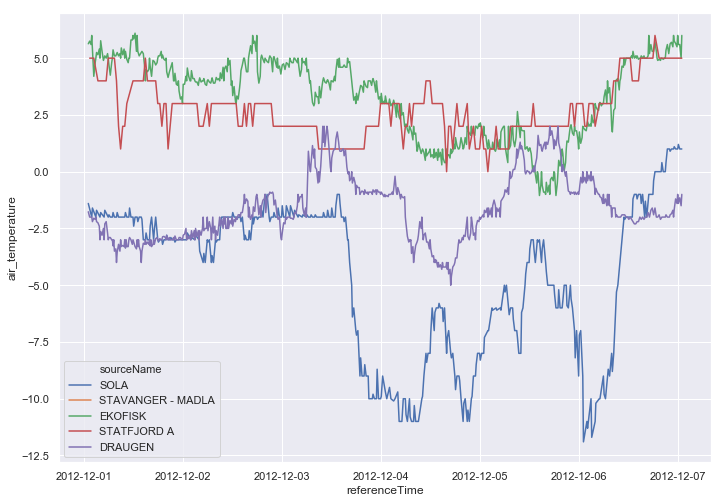

In [76]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="referenceTime", y="air_temperature",
             hue="sourceName",
             data=df)

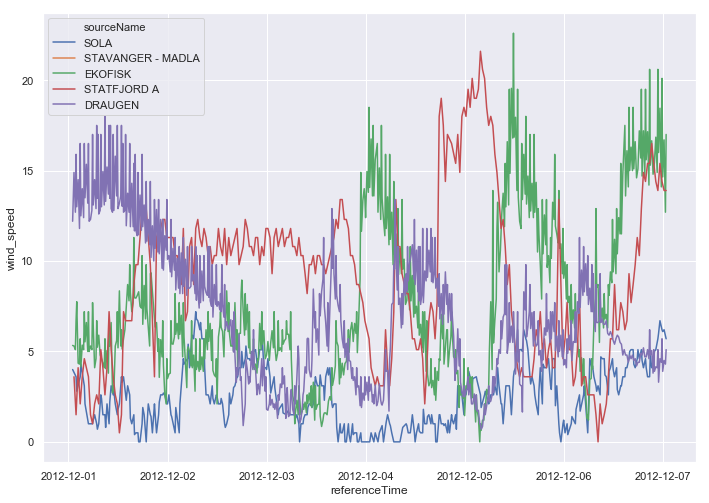

In [77]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="referenceTime", y="wind_speed",
             hue="sourceName",
             data=df)